# MLNet  

#### Implementation of Deep Multi-level Network for Saliency in Pytorch

#### Paper : Marcella Cornia, Lorenzo Baraldi, Giuseppe Serra, Rita Cucchiara. "A Deep Multi-Level Network for Saliency Prediction." In Proceedings of the 23rd International Conference on Pattern Recognition, 2016.

#### Reference Code : [link text](https://github.com/marcellacornia/mlnet)

## Setting 

Install required libraries

In [1]:
# ! pip install opencv-python
# ! pip install scikit-learn
# ! pip install torch
# ! pip install torchvision
# ! pip install torchmetrics
# ! pip install matplotlib

In [2]:
import cv2
import numpy as np 
import os 
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torchvision.models as models
from torchmetrics.classification import BinaryAUROC
import matplotlib.pyplot as plt
import time
import torchvision.transforms as transforms


In [3]:
# configuration

out_path = '/export/scratch/1inoba/' # path to store the output checkpoints and images

# path to dataset
imgs_train_path = "/export/scratch/CV2/images/train/"
maps_train_path = "/export/scratch/CV2/fixations/train/"

imgs_val_path = "/export/scratch/CV2/images/validation/"
maps_val_path =  "/export/scratch/CV2/fixations/validation/"

imgs_test_path = "/export/scratch/CV2/images/test/"

# Pre-processing Function and Generator


### Pre-processing Function

**Pre-Process Images**: Converts Input Images to 4:3 ration and use padding function for padding zeros. and it also pre-process for VGG-16 Architure substracting Mean from all channels.

**Pre-Process Maps**: Converts Output Images (Saliency Maps) to 4:3 ration and use padding function for padding zeros. and it also convert gray scale range of 0-255 to 0-1.

Note: pre-process, pre-process maps and padding are taken from reference code.

In [4]:
def padding(img, shape_r=480, shape_c=640, channels=3):
    img_padded = np.zeros((shape_r, shape_c, channels), dtype=np.uint8)
    if channels == 1:
        img_padded = np.zeros((shape_r, shape_c), dtype=np.uint8)

    original_shape = img.shape
    rows_rate = original_shape[0]/shape_r
    cols_rate = original_shape[1]/shape_c

    if rows_rate > cols_rate:
        new_cols = (original_shape[1] * shape_r) // original_shape[0]
        img = cv2.resize(img, (new_cols, shape_r))
        if new_cols > shape_c:
            new_cols = shape_c
        img_padded[:, ((img_padded.shape[1] - new_cols) // 2):((img_padded.shape[1] - new_cols) // 2 + new_cols)] = img
    else:
        new_rows = (original_shape[0] * shape_c) // original_shape[1]
        img = cv2.resize(img, (shape_c, new_rows))
        if new_rows > shape_r:
            new_rows = shape_r
        img_padded[((img_padded.shape[0] - new_rows) // 2):((img_padded.shape[0] - new_rows) // 2 + new_rows), :] = img

    return img_padded


def preprocess_images(paths, shape_r, shape_c):
    ims = np.zeros((len(paths), shape_r, shape_c, 3))

    for i, path in enumerate(paths):
        original_image = cv2.imread(path)
        padded_image = padding(original_image, shape_r, shape_c, 3)
        ims[i] = padded_image.astype('float')
        
    
#     cv2 : BGR
#     PIL : RGB
    ims = ims[...,::-1]
    ims /= 255.0
    ims = np.rollaxis(ims, 3, 1)  
    
    return ims


def preprocess_maps(paths, shape_r, shape_c):
    ims = np.zeros((len(paths), 1, shape_r, shape_c))

    for i, path in enumerate(paths):
        original_map = cv2.imread(path, 0)
        padded_map = padding(original_map, shape_r, shape_c, 1)
        ims[i, 0] = padded_map.astype(np.float32)
        ims[i, 0] /= 255.0
        

    return ims

### Generator

**generator**: It is used to supply images during training/testing with specified batch sizes. Function is modified from reference code. Shuffle and breaking condition of loop is added.

In [5]:
def generator(b_s, shape_r, shape_c, shape_r_gt, shape_c_gt, phase_gen='train'):
    if phase_gen == 'train':
        images = [imgs_train_path + f for f in os.listdir(imgs_train_path) if f.endswith('.png')]
        maps = [maps_train_path + f for f in os.listdir(maps_train_path) if f.endswith('.png')]
    elif phase_gen == 'val':
        images = [imgs_val_path + f for f in os.listdir(imgs_val_path) if f.endswith('.png')]
        maps = [maps_val_path + f for f in os.listdir(maps_val_path) if f.endswith('.png')]
        pass
    elif phase_gen == 'test':
        images = [imgs_test_path + f for f in os.listdir(imgs_test_path) if f.endswith('.png')]
        pass
    else:
        raise NotImplementedError
    
    images.sort()

    if phase_gen == 'train' or phase_gen == 'val': 
        maps.sort()
        images , maps = shuffle(images,maps)
    
    counter = 0
        
    while True:
        if phase_gen == 'train' or phase_gen == 'val': 
            yield preprocess_images(images[counter:counter + b_s], shape_r, shape_c), preprocess_maps(maps[counter:counter + b_s], shape_r_gt, shape_c_gt)
        elif phase_gen == 'test':
            yield preprocess_images(images[counter:counter + b_s], shape_r, shape_c)
        
        if counter + b_s >= len(images):
            break
        counter = counter + b_s

## Defining Model and Loss Function

### Defining Model

More Detail of Model in Paper : https://arxiv.org/abs/1609.01064

![Model](https://raw.githubusercontent.com/marcellacornia/mlnet/master/figs/mlnet.jpg)

In [6]:
class MLNet(nn.Module):
    
    def __init__(self,prior_size):
        super(MLNet, self).__init__()
        # loading pre-trained vgg16 model and         
        # removing last max pooling layer
        features = list(models.vgg16(pretrained = True).features)[:-1]
        
        # making same spatial size
        # by calculation :) 
        # in pytorch there was problem outputing same size in maxpool2d
        features[23].stride = 1
        features[23].kernel_size = 5
        features[23].padding = 2
                
        self.features = nn.ModuleList(features).eval() 
        # adding dropout layer
        self.fddropout = nn.Dropout2d(p=0.5)
        # adding convolution layer to down number of filters 1280 ==> 64
        self.int_conv = nn.Conv2d(1280,64,kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pre_final_conv = nn.Conv2d(64,1,kernel_size=(1, 1), stride=(1, 1) ,padding=(0, 0))
        # prior initialized to ones
        self.prior = nn.Parameter(torch.ones((1,1,prior_size[0],prior_size[1]), requires_grad=True))
        
        # bilinear upsampling layer
        self.bilinearup = torch.nn.UpsamplingBilinear2d(scale_factor=10)
        
    def forward(self, x):
        
        results = []
        for ii,model in enumerate(self.features):
            x = model(x)
            if ii in {16,23,29}:
                results.append(x)
        
        # concat to get 1280 = 512 + 512 + 256
        x = torch.cat((results[0],results[1],results[2]),1) 
        
        # adding dropout layer with dropout set to 0.5 (default)
        x = self.fddropout(x)
        
        # 64 filters convolution layer
        x = self.int_conv(x)
        # 1*1 convolution layer
        x = self.pre_final_conv(x)
        
        upscaled_prior = self.bilinearup(self.prior)
        # print ("upscaled_prior shape: {}".format(upscaled_prior.shape))

        # dot product with prior
        x = x * upscaled_prior
        x = torch.nn.functional.relu(x,inplace=True)
        return x


### Defining Custom Loss function derived From MSE Loss

In [7]:
# Modified MSE Loss Function
class ModMSELoss(torch.nn.Module):
    def __init__(self,shape_r_gt,shape_c_gt):
        super(ModMSELoss, self).__init__()
        self.shape_r_gt = shape_r_gt
        self.shape_c_gt = shape_c_gt
        
    def forward(self, output , label , prior):
        prior_size = prior.shape
        output_max = torch.max(torch.max(output,2)[0],2)[0].unsqueeze(2).unsqueeze(2).expand(output.shape[0],output.shape[1],self.shape_r_gt,self.shape_c_gt)
        reg = ( 1.0/(prior_size[0]*prior_size[1]) ) * ( 1 - prior)**2
        loss = torch.mean( ((output / output_max) - label)**2 / (1 - label + 0.1) )  +  torch.sum(reg)
        return loss

# Training Model

#### Memory Warning: 

This model require huge amount of memory. Paper doesn't freeze any layer and uses configratution of Image size = (480,640) , batch_size = 10.
Training with default configration result into cuda out of memory (12 GB of GPU RAM).

To tackle this problem, I have tried to train model on two variant.
> 1.

       shape_r = 240 ==> shape_r_gt = 30
       shape_c = 320 ==> shape_c_gt = 40
       batch_size = 16
       last_freeze_layer = 23
> 2.

       shape_r = 480 ==> shape_r_gt = 60
       shape_c = 640 ==> shape_c_gt = 80
       batch_size = 16
       last_freeze_layer = 28
       
       
**Note : Second Approch didn't perform well.**

#### Prior Size:

prior size (w',h') where w' << w and h' << h as mentioned in paper where w,h are width and height of output.

**w' =  w  / 10**

**h'  =  h  / 10**


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
# Input Images size
shape_r = 240
shape_c = 320
# shape_r = 480
# shape_c = 640

# Output Image size (generally divided by 8 from Input size)
shape_r_gt = 30
shape_c_gt = 40
# shape_r_gt = 60
# shape_c_gt = 80


last_freeze_layer = 23
# last_freeze_layer = 28

Define prior, loss function, optimizer, evaluation matrics

In [10]:
# ! wget https://drive.usercontent.google.com/download?id=0B3ZguV08iwjsOGFEWlRfZkVqaWs&export=download&authuser=0&resourcekey=0-qNclY0CYQk2R8xaS2HuAaA

In [11]:
# PATH = out_path + "download?id=0B3ZguV08iwjsOGFEWlRfZkVqaWs"
# model = torch.load(PATH)
# model

In [12]:
# fine-tune the baseline
prior_size = ( int(shape_r_gt / 10) , int(shape_c_gt / 10) )
model = MLNet(prior_size).to(device)

# load model and fine-tune trained model
# PATH = out_path + "download?id=0B3ZguV08iwjsOGFEWlRfZkVqaWs"
# model = torch.load(PATH).device()


# freezing Layer
for i,param in enumerate(model.parameters()):
  if i < last_freeze_layer:
    param.requires_grad = False


criterion = ModMSELoss(shape_r_gt,shape_c_gt).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay=1e-4)

metric = BinaryAUROC()


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=mean,
                                 std=std)



/export/home/1inoba/infhome/CV2/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/export/home/1inoba/infhome/CV2/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training

In [13]:

loss_history = []
nb_epochs = 1
batch_size = 16 # batch_size=16 -> 3.5 GB, batch_size=32 -> 5GB 
val_freq = 1
min_val_loss = float("inf")
auroc_scores = []

for epoch in range(nb_epochs):
  t1 = time.time()
  image_trained = 0

  for i,gt_map in generator(batch_size, shape_r, shape_c, shape_r_gt, shape_c_gt, phase_gen='train'):

      optimizer.zero_grad()
      
      # assert np.any(np.isnan(i)), "Input contains NAN value!"
      if np.any(np.isnan(i)):
        print("input has nan")

      i,gt_map = torch.tensor(i.copy(),dtype=torch.float),torch.tensor(gt_map,dtype=torch.float)
      
      for idx,x in enumerate(i):
        i[idx] = normalize(x)
      i, gt_map = i.to(device), gt_map.to(device)

      image_trained += batch_size

      out = model.forward(i)
      loss = criterion(out,gt_map,model.prior.clone())
      loss.backward()
      optimizer.step()

      if image_trained % (batch_size*20) == 0:
        print ("Epcohs:{} Images:{} Loss:{}".format(epoch,image_trained,loss.item()) )
  t2 = time.time()
  time_per_epoch = (t2 - t1) / 60.0
  print ('Time taken for epoch-{} : {}m'.format(epoch,time_per_epoch))


# validation
  if nb_epochs % val_freq == 0:
    model.eval()
    with torch.no_grad():
      image_validated = 0
      val_loss = 0
      auroc_score = 0
      
      for i, gt_map in generator(batch_size, shape_r, shape_c, shape_r_gt, shape_c_gt, phase_gen='val'):
        i, gt_map = torch.tensor(i.copy(),dtype=torch.float),torch.tensor(gt_map,dtype=torch.float)
        for idx, x in enumerate(i):
          i[idx] = normalize(x)
        i, gt_map = i.to(device), gt_map.to(device)

        image_validated += batch_size

        out = model.forward(i)
        val_loss += criterion(out, gt_map, model.prior.clone()).item()
        auroc_score += metric(out.flatten(), gt_map.flatten())
        
      val_loss /= image_validated
      auroc_score /= image_validated
      auroc_scores.append(auroc_score)
      
      print ("Epcohs:{} Images:{} Validation Loss:{} AUROC Score {}".format(epoch,image_validated, val_loss, auroc_score) )


    # early stopping
    if val_loss < min_val_loss:
      min_val_loss = val_loss
      cp_path = out_path + f"checkpoint{epoch}.pth"
      torch.save(
          {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
          },
          cp_path,
      )
      print(f"Saved checkpoint to {cp_path}")

Epcohs:0 Images:320 Loss:nan
Epcohs:0 Images:640 Loss:0.04161794111132622
Epcohs:0 Images:960 Loss:nan
Epcohs:0 Images:1280 Loss:0.02724054642021656
Epcohs:0 Images:1600 Loss:0.034779343754053116
Epcohs:0 Images:1920 Loss:0.036713242530822754
Epcohs:0 Images:2240 Loss:0.032254669815301895
Epcohs:0 Images:2560 Loss:0.044182196259498596
Epcohs:0 Images:2880 Loss:0.025232894346117973
Time taken for epoch-0 : 0.6358745296796163m


/export/home/1inoba/infhome/CV2/.venv/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Epcohs:0 Images:1136 Validation Loss:0.0016769685284037826 AUROC Score 0.030752534046769142
Saved checkpoint to /export/scratch/1inoba/checkpoint0.pth


In [21]:
out.shape

torch.Size([1, 1, 30, 40])

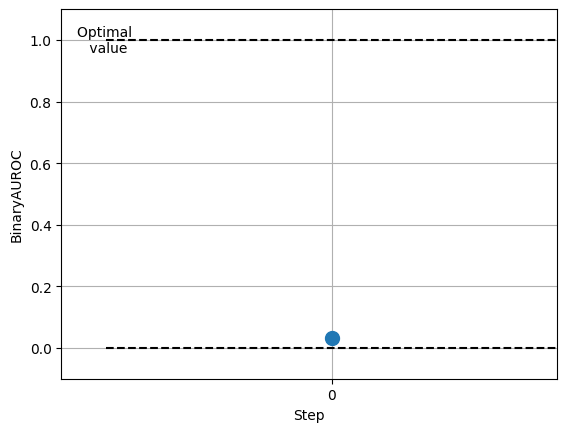

In [14]:
fig_, ax_ = metric.plot(auroc_scores)

## Visualizing Model Output  
visualize input image, predicted fixation map and groud truth from the validation data

In [15]:
# # load the specific checkpoint


# num_epoch = 10
# cp_path = out_path + f"checkpoint{num_epoch}.pth"
# checkpoint = torch.load(cp_path)
# model.load_state_dict(checkpoint['model_state_dict'])

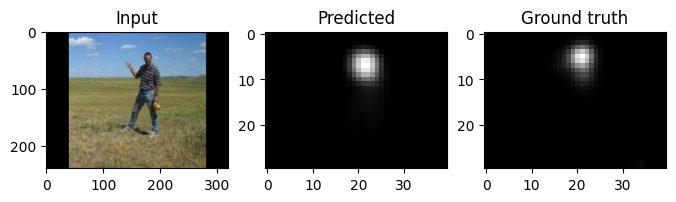

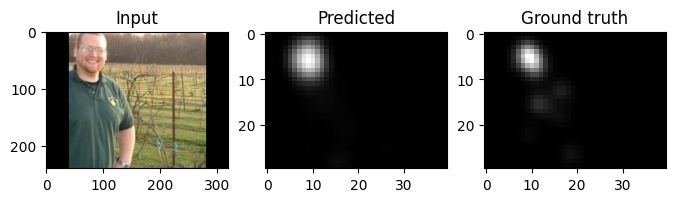

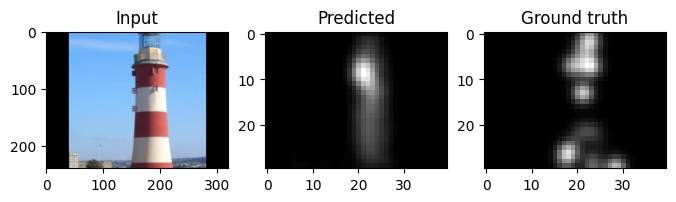

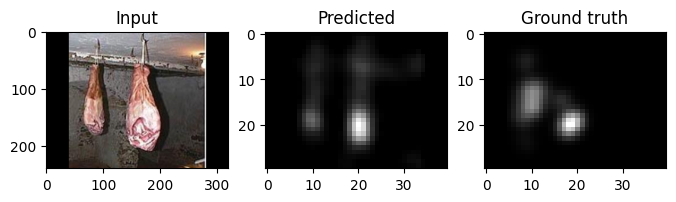

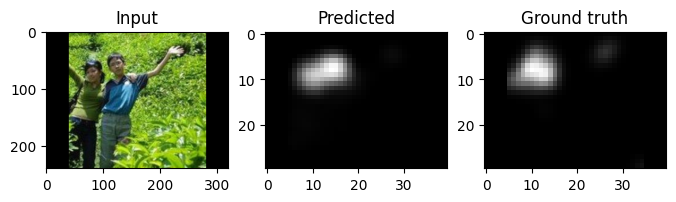

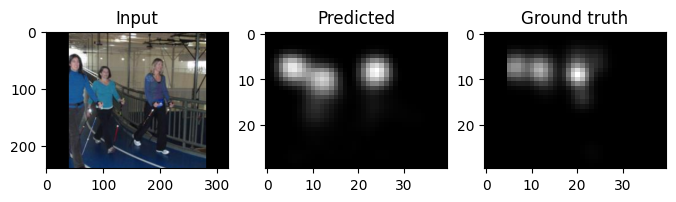

In [16]:
# how many pic you want to visualiz at randomly
no_visual = 5


visual_cnt = 0
for i,gt_map in generator(1, shape_r, shape_c, shape_r_gt, shape_c_gt, phase_gen='val'):
    org_image = i[0].copy()
    
    org_image = np.rollaxis(org_image, 0, 3) 

    i = torch.tensor(i.copy(),dtype=torch.float)
    for idx,x in enumerate(i):
        i[idx] = normalize(x)
    i = i.cuda()
    out = model.forward(i)
    
    out_img = out[0].squeeze(0).data.cpu().numpy()
    
    f, axarr = plt.subplots(1,3, figsize=(8,10))
    axarr[0].imshow(org_image)
    axarr[1].imshow(out_img, cmap='gray')
    axarr[2].imshow(gt_map[0][0], cmap='gray')
    
    axarr[0].set_title('Input')
    axarr[1].set_title('Predicted')
    axarr[2].set_title('Ground truth')
    plt.show()
    
    plt.imsave(out_path + f'val_original_{visual_cnt}.png', org_image)
    plt.imsave(out_path + f'val_predicted_{visual_cnt}.png', out_img)
    plt.imsave(out_path + f'val_groud_truth_{visual_cnt}.png', gt_map[0][0])
    
    
    visual_cnt += 1
    if visual_cnt > no_visual:
      break

# Inference
Input test images and predict the eye fixation map

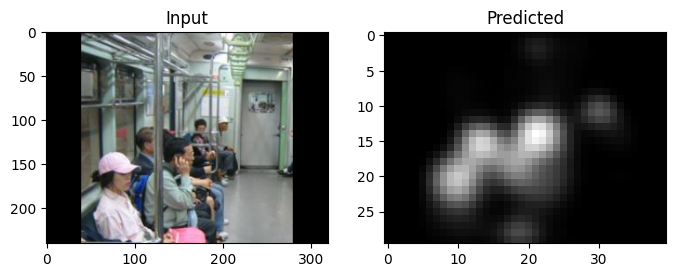

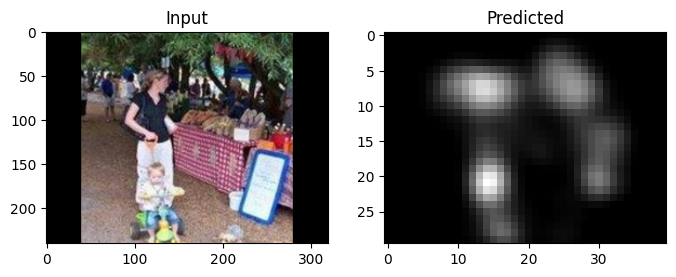

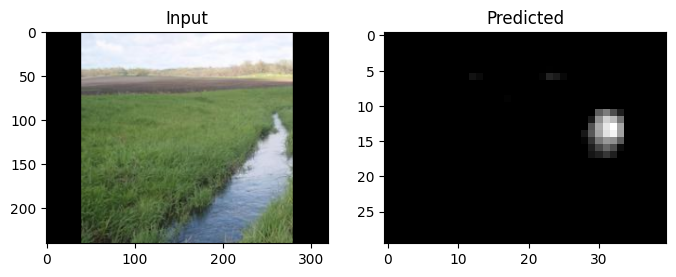

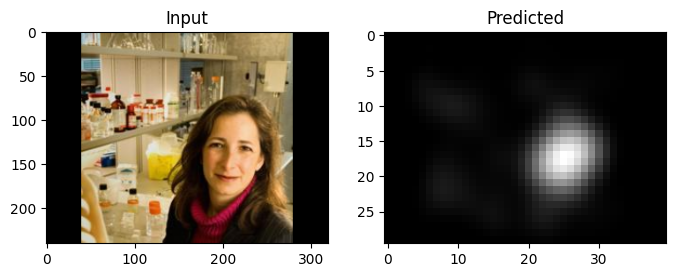

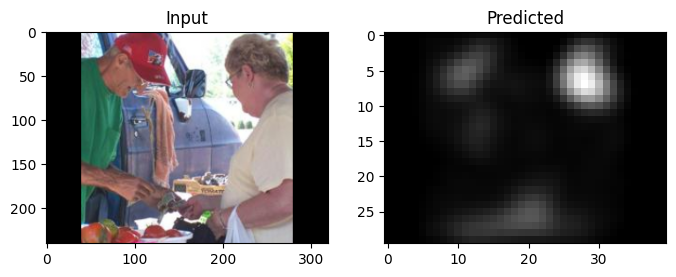

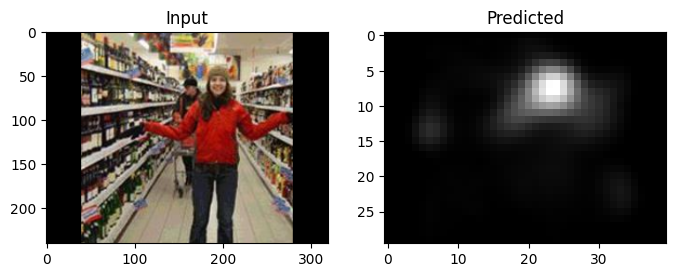

In [17]:
# how many pic you want to visualiz at randomly
no_visual = 5

# inference
visual_cnt = 0
for i in generator(1, shape_r, shape_c, shape_r_gt, shape_c_gt, phase_gen='test'):
    org_image = i[0].copy()
    
    org_image = np.rollaxis(org_image, 0, 3) 

    i = torch.tensor(i.copy(),dtype=torch.float)
    for idx,x in enumerate(i):
        i[idx] = normalize(x)
    i = i.cuda()
    out = model.forward(i)
    
    out_img = out[0].squeeze(0).data.cpu().numpy()
    
    # plot the input image and predicted fixation map
    f, axarr = plt.subplots(1,2, figsize=(8,10))
    axarr[0].imshow(org_image)
    axarr[1].imshow(out_img, cmap='gray')
    
    axarr[0].set_title('Input')
    axarr[1].set_title('Predicted')
    plt.show()
    
    plt.imsave(out_path + f'test_original_{visual_cnt}.png', org_image)
    plt.imsave( out_path + f'test_original_{visual_cnt}.png', org_image)
    
    plt.imsave(out_path + f'test_predicted_{visual_cnt}.png', out_img)

    visual_cnt += 1
    if visual_cnt > no_visual:
      break